In [1]:
## imports ##

import sys
sys.path.append("../PythonScripts")
import preprocessing_utils as prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm, decomposition, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import synapseclient as sc
%matplotlib inline

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)

/Users/atediarjo/Documents/SageBionetworks/synapse_venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Contents:

- Gait data being used is based on the PDKit mPowerV1 data, collapsed by each healthCode ids
- Features chosen are based on a walking_feature_analysis.ipnb
- For this ML Analysis, we will split the training-test set by 75%-25% 
- Models being used: Logistic Regression, Xtreme Gradient Boost, Sklearn Gradient Boost and Random Forests as a baseline
- Feature selection will be done automatically by using sklearn SelectFromModel function, that follows embedded feature selection process
- Hyperparameter tuning will be done through a python script that will be run in an EC2 instance (not here)
- Feature Importances will be based on baseline model
- Learning Curves of each model

## Helper Functions

In [2]:
def logreg_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(ExtraTreesClassifier(n_estimators = 100,
                                                                   random_state  = 100))),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state = 100))
        ])
    param = {}
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV


def xgb_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(ExtraTreesClassifier(n_estimators = 100,
                                                            random_state  = 100))),
        ('classifier', XGBClassifier(seed = 100))
        ])
    param = {}
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV
    

def gradientboost_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(estimator = ExtraTreesClassifier(n_estimators = 100,
                                                                              random_state  = 100))),
        ('classifier', GradientBoostingClassifier(random_state = 100))
        ])
    param = {}
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV

def randomforest_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(estimator = ExtraTreesClassifier(n_estimators = 100,
                                                                              random_state = 100))),
        ('classifier', RandomForestClassifier(random_state = 100))
    ])
    param = {}
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV


def printPerformance(model, X_test, y_test):
    print("Mean AUC score on K-folds: {}".format(model.best_score_))
    print("Parameter Used: {}".format(model.best_params_))
    y_true, y_pred = y_test, model.predict(X_test)
    print("ROC-AUC on Test-Set: {}".format(metrics.roc_auc_score(y_true, y_pred)))
    print("log-loss: {}".format(metrics.log_loss(y_true, y_pred)))
    print("Precision: {}".format(metrics.precision_score(y_true, y_pred)))
    print("Recall: {}".format(metrics.recall_score(y_true, y_pred)))
    print("F1-Score: {}".format(metrics.f1_score(y_true, y_pred)))

## Get Baseline Model and Feature Engineered Data

In [3]:
syn = sc.login()

Welcome, aryton tediarjo!



In [4]:
## Baseline ## 
entity = syn.get("syn21046180")
data   = pd.read_csv(entity["path"], index_col = 0)

In [5]:
feature_columns = [feat for feat in data.columns if ("." in feat) 
                   or ("duration" in feat) or ("healthCode" in feat)]
metadata_columns = [feat for feat in data.columns if "." not in feat]

In [6]:
## Baseline model without collapsed features ##
walking_X_train, walking_X_test, walking_y_train, walking_y_test = \
            train_test_split(data[feature_columns], 
                             data["PD"], test_size=0.25, random_state = 100)

## Run Model on Walking Data

In [45]:
def split_dataset(data):
    ## list of feature columns ## 
    feature_columns = [feat for feat in data.columns if ("." in feat)]
    ## Baseline model without collapsed features ##
    X_train, X_test, y_train, y_test = \
            train_test_split(data[feature_columns], 
                             data["PD"], test_size=0.25, random_state = 100)
    return X_train, X_test, y_train, y_test

def run_some_models(data):
    
    X_train, X_test, y_train, y_test = split_dataset(data)
    ## run preliminary models ##
    lr_walking_model = logreg_fit(X_train, 
                                  y_train)
    rf_walking_model = randomforest_fit(X_train, 
                                        y_train)
    gb_walking_model = gradientboost_fit(X_train, 
                                         y_train)
    xgb_walking_model = xgb_fit(X_train, 
                                y_train)
    print("########################################")
    print("Gradient Boosting Walking")
    print("########################################")
    printPerformance(gb_walking_model, X_test, y_test)
    print("\n")
    
    
    print("##########################################")
    print("XTreme Gradient Boosting Walking")
    print("########################################")
    printPerformance(xgb_walking_model, X_test, y_test)
    print("\n")
    
    
    print("##########################################")
    print("Random Forest Walking")
    print("########################################")
    printPerformance(rf_walking_model, X_test, y_test)
    print("\n")
    
    
    print("##########################################")
    print("Logistic Regression Walking")
    print("########################################")
    printPerformance(lr_walking_model, X_test, y_test)
    print("\n")
    
    return lr_walking_model, rf_walking_model, gb_walking_model, xgb_walking_model

### a). Model 1 - Max aggregated baseline model without feature engineering

In [46]:
## model on max collapsed features feature engineered ##
test_data = prep.preprocess(data, "max", is_feature_engineered = False) 
lr_model_1, rf_model_1, gb_model_1, xgb_model_1 = \
                          run_some_models(test_data)

########################################
Gradient Boosting Walking
########################################
Mean AUC score on K-folds: 0.5221974206349205
Parameter Used: {}
ROC-AUC on Test-Set: 0.5576923076923077
log-loss: 15.11088125557138
Precision: 0.5238095238095238
Recall: 0.5
F1-Score: 0.5116279069767442


##########################################
XTreme Gradient Boosting Walking
########################################
Mean AUC score on K-folds: 0.5806051587301588
Parameter Used: {}
ROC-AUC on Test-Set: 0.6608391608391609
log-loss: 11.513042072928798
Precision: 0.65
Recall: 0.5909090909090909
F1-Score: 0.6190476190476191


##########################################
Random Forest Walking
########################################
Mean AUC score on K-folds: 0.585751488095238
Parameter Used: {}
ROC-AUC on Test-Set: 0.6835664335664335
log-loss: 10.79348423136816
Precision: 0.6666666666666666
Recall: 0.6363636363636364
F1-Score: 0.6511627906976744


###################################

### b). Model 2 - Max Aggregated Model with feature engineering

In [47]:
## model on max collapsed features ##
test_data = prep.preprocess(data, "max", is_feature_engineered = True) 
lr_model_2, rf_model_2, gb_model_2, xgb_model_2 = \
                          run_some_models(test_data)

########################################
Gradient Boosting Walking
########################################
Mean AUC score on K-folds: 0.587921626984127
Parameter Used: {}
ROC-AUC on Test-Set: 0.6223776223776224
log-loss: 12.952191072609667
Precision: 0.5909090909090909
Recall: 0.5909090909090909
F1-Score: 0.5909090909090909


##########################################
XTreme Gradient Boosting Walking
########################################
Mean AUC score on K-folds: 0.6212797619047621
Parameter Used: {}
ROC-AUC on Test-Set: 0.596153846153846
log-loss: 13.671732255890511
Precision: 0.5789473684210527
Recall: 0.5
F1-Score: 0.5365853658536586


##########################################
Random Forest Walking
########################################
Mean AUC score on K-folds: 0.6301463293650793
Parameter Used: {}
ROC-AUC on Test-Set: 0.5052447552447552
log-loss: 16.549963622133067
Precision: 0.4666666666666667
Recall: 0.3181818181818182
F1-Score: 0.3783783783783784


####################

### c). Model 3 - Max and Mean Aggregeated Model with feature engineering

In [49]:
max_test_data = prep.preprocess(data, "max", is_feature_engineered = True) 
mean_test_data = prep.preprocess(data, "mean", is_feature_engineered = True) 

combined_test_data = pd.concat([max_test_data, mean_test_data], axis = 1)
combined_test_data = combined_test_data.loc[:,~combined_test_data.columns.duplicated()]
lr_model_3, rf_model_3, gb_model_3, xgb_model_3 = \
                          run_some_models(combined_test_data)

########################################
Gradient Boosting Walking
########################################
Mean AUC score on K-folds: 0.47867063492063494
Parameter Used: {}
ROC-AUC on Test-Set: 0.687062937062937
log-loss: 10.793500889647953
Precision: 0.6521739130434783
Recall: 0.6818181818181818
F1-Score: 0.6666666666666666


##########################################
XTreme Gradient Boosting Walking
########################################
Mean AUC score on K-folds: 0.5261656746031745
Parameter Used: {}
ROC-AUC on Test-Set: 0.7027972027972027
log-loss: 10.073909731527724
Precision: 0.7
Recall: 0.6363636363636364
F1-Score: 0.6666666666666666


##########################################
Random Forest Walking
########################################
Mean AUC score on K-folds: 0.5753968253968256
Parameter Used: {}
ROC-AUC on Test-Set: 0.6118881118881119
log-loss: 12.95214109777028
Precision: 0.625
Recall: 0.45454545454545453
F1-Score: 0.5263157894736842


###############################

The results above shows that the unfeatured data has better capability to predict the test sets, the same goes to the combined datasets of maximum and minimum aggregated together. However, the maximum aggregated data model is performing much more stable in its cross validated tests.

# Some Result Metrics

In [50]:
model_data = prep.preprocess(data, "max", is_feature_engineered = True) 
X_train, X_test, y_train, y_test = split_dataset(model_data)

In [35]:
for model in [lr_model_2, rf_model_2, gb_model_2, xgb_model_2]:
    print("######################################################")
    print(type(model.best_estimator_["classifier"]).__name__)
    print("######################################################")
    print(metrics.classification_report(model.predict(X_test), y_test))

######################################################
LogisticRegression
######################################################
              precision    recall  f1-score   support

           0       0.65      0.68      0.67        25
           1       0.64      0.61      0.62        23

    accuracy                           0.65        48
   macro avg       0.65      0.64      0.64        48
weighted avg       0.65      0.65      0.65        48

######################################################
RandomForestClassifier
######################################################
              precision    recall  f1-score   support

           0       0.69      0.55      0.61        33
           1       0.32      0.47      0.38        15

    accuracy                           0.52        48
   macro avg       0.51      0.51      0.49        48
weighted avg       0.58      0.52      0.54        48

######################################################
GradientBoostingClassifier
##

# Feature Importances based on Embedded Methods

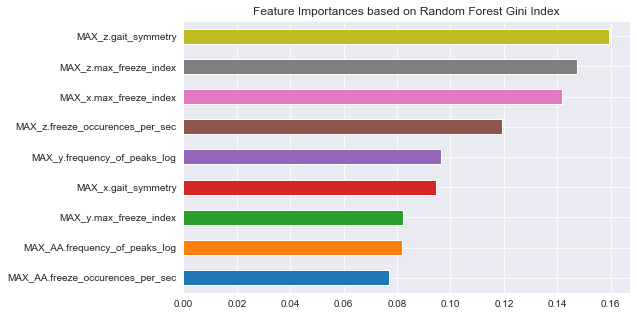

In [64]:
series = pd.Series(data = rf_model_2.best_estimator_["classifier"].feature_importances_, 
          index = X_train.columns[rf_model_2.best_estimator_["feature_selection"].get_support()]).sort_values(ascending = True)
plt.figure(figsize = (8,5))
plt.title("Feature Importances based on Random Forest Gini Index")
series.plot(kind = "barh")
plt.grid()

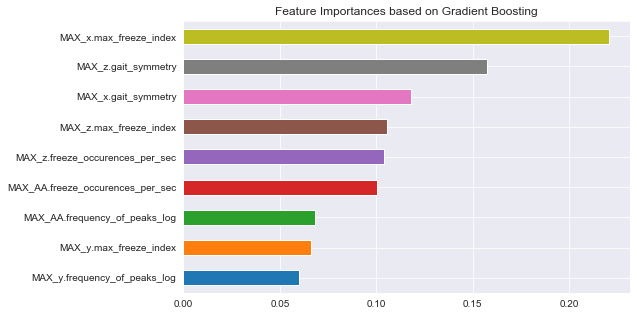

In [65]:
series = pd.Series(data = gb_model_2.best_estimator_["classifier"].feature_importances_, 
          index = X_train.columns[gb_model_2.best_estimator_["feature_selection"].get_support()]).sort_values(ascending = True)
plt.figure(figsize = (8,5))
plt.title("Feature Importances based on Gradient Boosting")
series.plot(kind = "barh")
plt.grid()

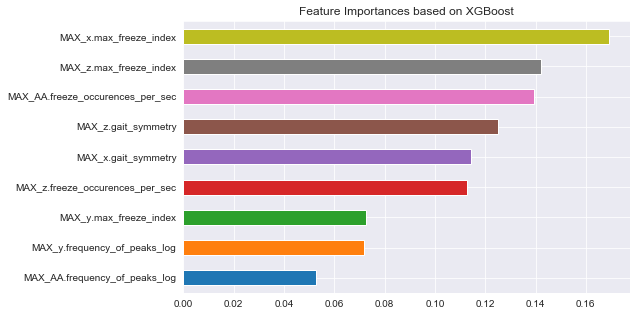

In [67]:
series = pd.Series(data = xgb_model_2.best_estimator_["classifier"].feature_importances_, 
          index = X_train.columns[xgb_model_2.best_estimator_["feature_selection"].get_support()]).sort_values(ascending = True)
plt.figure(figsize = (8,5))
plt.title("Feature Importances based on XGBoost")
series.plot(kind = "barh")
plt.grid()

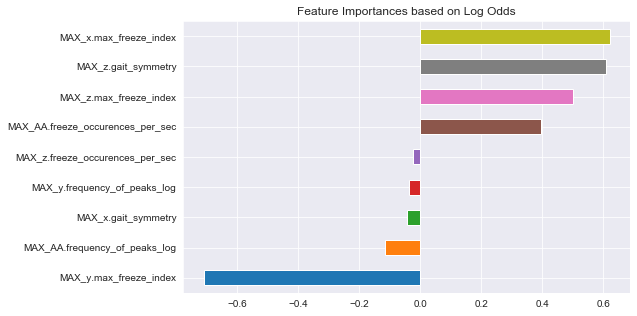

In [86]:
series = pd.Series(data = lr_model_2.best_estimator_["classifier"].coef_[0], 
          index = X_train.columns[lr_model_2.best_estimator_["feature_selection"].get_support()]).sort_values(ascending = True)
plt.figure(figsize = (8,5))
plt.title("Feature Importances based on Log Odds")
series.plot(kind = "barh")
plt.grid()

# Learning Curves

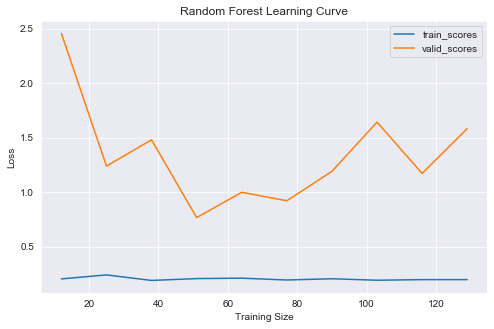

In [102]:
train_sizes, train_scores, valid_scores = learning_curve(rf_model_2.best_estimator_, 
                                                         X_train, y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot(figsize = (8,5))
plt.ylabel("Loss")
plt.title("Random Forest Learning Curve")
plt.xlabel("Training Size")
plt.grid()
plt.show()

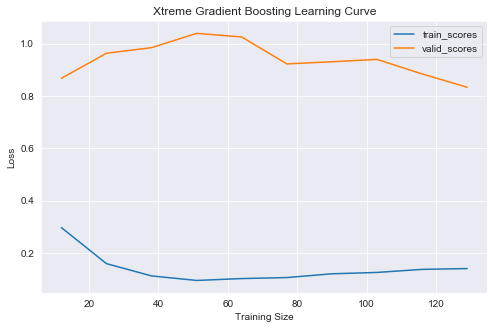

In [103]:
train_sizes, train_scores, valid_scores = learning_curve(xgb_model_2.best_estimator_, 
                                                         X_train, y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, 
                                                         random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot(figsize = (8,5))
plt.ylabel("Loss")
plt.title("Xtreme Gradient Boosting Learning Curve")
plt.xlabel("Training Size")
plt.grid()
plt.show()

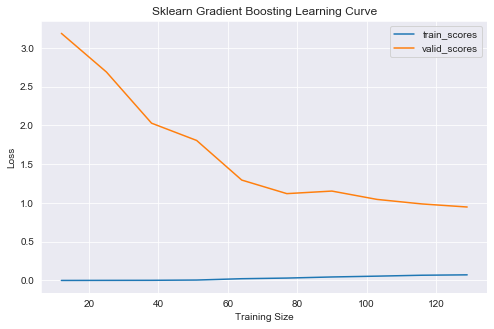

In [104]:
train_sizes, train_scores, valid_scores = learning_curve(gb_model_2.best_estimator_, 
                                                         X_train, y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, 
                                                         random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot(figsize = (8,5))
plt.ylabel("Loss")
plt.title("Sklearn Gradient Boosting Learning Curve")
plt.xlabel("Training Size")
plt.grid()
plt.show()

# WORK IN PROGRESS 
will continue after better balance features

# Balance Data (WIP)

In [30]:
balance_train = pd.read_csv("../Data/BALANCE_TRAINING_DATA.csv", index_col=0).reset_index(drop = True)
balance_X_train, balance_X_test, balance_y_train, balance_y_test = \
train_test_split(balance_train.drop(["PD"],axis = 1), balance_train["PD"], test_size=0.20, random_state = 100)

In [31]:
lr_balance_model = logreg_fit(balance_X_train, balance_y_train)
rf_balance_model = randomforest_fit(balance_X_train, balance_y_train)
gb_balance_model = gradientboost_fit(balance_X_train, balance_y_train)
xgb_balance_model = xgb_fit(balance_X_train, balance_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_balance_model, balance_X_test, balance_y_test)
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_balance_model, balance_X_test, balance_y_test)
print("\n### Random Forest Walking ###")
printPerformance(rf_balance_model, balance_X_test, balance_y_test)
print("\n### Logistic Regression Walking ###")
printPerformance(lr_balance_model, balance_X_test, balance_y_test)


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.7145191409897292
Parameter Used: {'classifier__learning_rate': 0.001, 'classifier__loss': 'deviance', 'classifier__max_depth': 2, 'classifier__n_estimators': 100}
ROC-AUC on Test-Set: 0.46825396825396826
log-loss: 19.48382237529844
Precision: 0.4444444444444444
Recall: 0.8888888888888888
F1-Score: 0.5925925925925926

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6674836601307189
Parameter Used: {'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'classifier__tree_method': 'hist'}
ROC-AUC on Test-Set: 0.46825396825396826
log-loss: 18.59806920665941
Precision: 0.43478260869565216
Recall: 0.5555555555555556
F1-Score: 0.4878048780487805

### Random Forest Walking ###
Mean AUC score on K-folds: 0.6847572362278244
Parameter Used: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__m

# Combining Features in Balance and Walking

In [113]:
from sklearn.feature_selection import SelectKBest, chi2

In [135]:
train = pd.concat([balance_train.drop("PD", axis = 1), walking_train], axis = 1)
train = train.groupby(train.columns, axis=1).mean().dropna()
combined_X_train, combined_X_test, combined_y_train, combined_y_test = \
train_test_split(train.drop(["PD"], axis = 1), train["PD"], test_size=0.20, random_state = 100)
selector = SelectKBest(chi2, k=15).fit(combined_X_train, combined_y_train)
pd.Series(data = selector.scores_, index = combined_X_train.columns).sort_values(ascending = False).head(15)

max_userAccel_y.frequency_of_peaks     3.442899e+08
max_userAccel_x.frequency_of_peaks     1.370186e+07
max_userAccel_AA.frequency_of_peaks    8.345348e+05
max_userAccel_z.frequency_of_peaks     4.602456e+04
max_userAccel_x.max_freeze_index       1.208810e+03
max_userAccel_z.max_freeze_index       8.897928e+02
max_userAccel_y.max_freeze_index       3.391854e+02
max_userAccel_x.freeze_occurences      4.986737e+01
max_userAccel_z.freeze_occurences      3.421301e+01
max_userAccel_y.freeze_occurences      1.917437e+01
max_userAccel_AA.freeze_occurences     1.778391e+01
max_userAccel_AA.max_freeze_index      1.230553e+01
max_userAccel_x.no_of_steps            2.433806e+00
max_userAccel_y.no_of_steps            5.537818e-01
max_userAccel_z.no_of_steps            3.679252e-01
dtype: float64

In [136]:
lr_balance_model = logreg_fit(combined_X_train, combined_y_train)
rf_balance_model = randomforest_fit(combined_X_train, combined_y_train)
gb_balance_model = gradientboost_fit(combined_X_train, combined_y_train)
xgb_balance_model = xgb_fit(combined_X_train, combined_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_balance_model, combined_X_test, combined_y_test)
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_balance_model, combined_X_test, combined_y_test)
print("\n### Random Forest Walking ###")
printPerformance(rf_balance_model, combined_X_test, combined_y_test)
print("\n### Logistic Regression Walking ###")
printPerformance(lr_balance_model, combined_X_test, combined_y_test)


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.7072510822510822
Parameter Used: {'classifier__learning_rate': 0.1, 'classifier__loss': 'exponential', 'classifier__max_depth': 6, 'classifier__n_estimators': 100}
ROC-AUC on Test-Set: 0.48351648351648346
log-loss: 18.285516772869254
Precision: 0.3684210526315789
Recall: 0.5384615384615384
F1-Score: 0.4375

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6821789321789321
Parameter Used: {'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'classifier__tree_method': 'auto'}
ROC-AUC on Test-Set: 0.5073260073260073
log-loss: 17.269646890741583
Precision: 0.3888888888888889
Recall: 0.5384615384615384
F1-Score: 0.45161290322580644

### Random Forest Walking ###
Mean AUC score on K-folds: 0.7160894660894661
Parameter Used: {'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__max_feature

# Saving Serialized Results

The walking models will be the only one taken for further assessment towards V2 data due to its decent performance of ROC-AUC > 0.6. Model will be refitted to the test sets.

In [55]:
import pickle
from sklearn.externals import joblib 

### Refit Model to Tests Sets

In [56]:
refitted_lr = lr_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_gb = gb_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_xgb = xgb_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_rf = rf_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)

In [57]:
models = ["refitted_lr", "refitted_gb", "refitted_xgb", "refitted_rf"]


for model in models:
    joblib.dump(globals()[model], '../Models/{}.pkl'.format(model))